In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

手写数字图像数据集

In [9]:
class DigitalImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, is_train=True):
        self.transform = transform  # 图像预处理和转换
        self.is_train = is_train    # 判别训练数据还是测试
        self.images = []            # 图像路径
        self.labels = []            # 图像类别标签
        if is_train:                # 加载训练数据
            for label in os.listdir(data_dir):
                label_dir = os.path.join(data_dir, label)
                if os.path.isdir(label_dir):
                    for img_file in os.listdir(label_dir):
                        img_path = os.path.join(label_dir, img_file)
                        self.images.append(img_path)
                        self.labels.append(int(label))
        else:                       # 加载测试数据
            for img_file in os.listdir(data_dir):
                if img_file.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(data_dir, img_file)
                    self.images.append(img_path)
                    self.labels.append(img_file)  # 保存文件名用于生成提交文件
    # 数据集规模
    def __len__(self):
        return len(self.images)
    # 提取指定数据集成员
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # 转换为灰度图
        if self.transform:
            image = self.transform(image)  # 图像预处理
        label = self.labels[idx]
        return image, label

数据预处理阶段

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备：{device}")
# 数据预处理
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])
model_save_path = r"E:\python\code\machine_vision\experiment\experiment3\model\cnn_mnist.pth"
# 加载训练数据集d
train_dataset = DigitalImageDataset('minist_dataset/training', transform=transform, is_train=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

使用设备：cuda


定义CNN模型

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU(),     # 引入非线性
            nn.MaxPool2d(2)# 池化
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 全连接层
        self.fc = nn.Linear(32 * 7 * 7, 10)
    # 前向传播
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # 扁平化处理
        return self.fc(x)

训练模型

In [12]:
def train_model(model, train_loader, device, save_path, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    # 保存训练模型
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses
    }, save_path)
    print(f"模型已保存至：{save_path}")
    print("训练完毕!")

In [ ]:
# 创建模型并训练
model = CNN().to(device)
train_model(model, train_loader, device, save_path=model_save_path, num_epochs=10)

分割并识别单张多数字图片

In [13]:
def process_multi_digit_image(img_path, model_path, device):
    # 图片预处理（分割数字）
    #读取图片
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"无法读取图片：{img_path}")
    # 转灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 二值化（白底黑字→黑底白字）
    _, binary_img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    # 降噪
    kernel = np.ones((2, 2), np.uint8)
    binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
    # 找数字轮廓并按顺序排序
    # 找最外层轮廓
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 筛选有效轮廓（排除过小的噪声）
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 20]
    # 按轮廓的x坐标排序
    valid_contours = sorted(valid_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
    # 加载训练好的模型
    model = CNN().to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    # 预处理每个数字、显示裁剪图、识别
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])
    digit_result = []
    # 创建显示窗口（统一尺寸）
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"分割后的单数字图片（原文件：{os.path.basename(img_path)}）", fontsize=14)
    for idx, cnt in enumerate(valid_contours):
        # 获取数字的 bounding box
        x, y, w, h = cv2.boundingRect(cnt)
        padding = 5
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(binary_img.shape[1] - x, w + 2 * padding)
        h = min(binary_img.shape[0] - y, h + 2 * padding)
        # 裁剪数字区域
        digit_roi = binary_img[y:y+h, x:x+w]
        # 显示裁剪后的单数字图片
        # 转换为RGB格式（适配matplotlib显示）
        digit_roi_rgb = cv2.cvtColor(digit_roi, cv2.COLOR_GRAY2RGB)
        # 创建子图显示
        plt.subplot(1, len(valid_contours), idx+1)
        plt.imshow(digit_roi_rgb)
        plt.axis('off')  # 关闭坐标轴
        # 识别数字
        digit_tensor = transform(digit_roi).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(digit_tensor)
            _, pred = torch.max(output, 1)
            pred_digit = str(pred.item())
            digit_result.append(pred_digit)
        # 子图标题标注识别结果
        plt.title(f"识别结果：{pred_digit}", fontsize=12)
    # 显示所有裁剪后的数字图片
    plt.tight_layout()
    plt.show()
    # 拼接所有数字结果
    final_result = ''.join(digit_result)
    return final_result

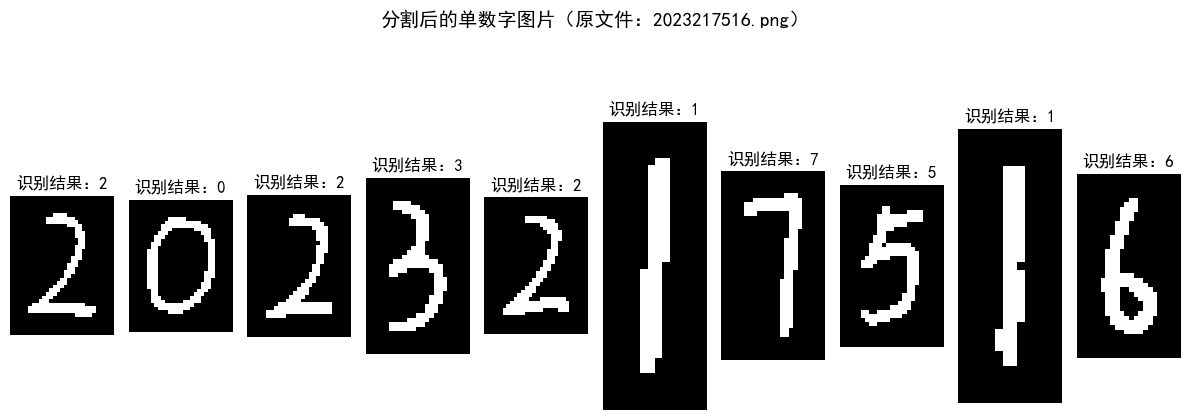


图片 2023217516.png 的识别结果：2023217516


In [14]:
multi_digit_img_path = r"E:\python\code\machine_vision\experiment\experiment3\2023217516.png"
# 调用多数字识别函数
final_result = process_multi_digit_image(multi_digit_img_path, model_save_path, device)
print(f"\n图片 {os.path.basename(multi_digit_img_path)} 的识别结果：{final_result}")